<a href="https://colab.research.google.com/github/amulyasrithota/airbnb-popularity/blob/main/airbnb_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/airbmbdataset.csv")

# 1. Drop duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values
df['name'] = df['name'].fillna("No name provided")
df['host_name'] = df['host_name'].fillna("Unknown")
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# 3. Convert 'last_review' to datetime
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

# 4. Remove logically invalid rows
df = df[df['minimum_nights'] > 0]
df = df[df['minimum_nights'] <= 365]
df = df[df['number_of_reviews'] >= 0]

# 5. Standardize column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
)

# 6. Validate and clean coordinates
df = df[df['latitude'].between(-90, 90)]
df = df[df['longitude'].between(-180, 180)]

# 7. Reset index
df = df.reset_index(drop=True)

# Optional: Display cleaned data info
print(df.info())

# Optional: Preview first few rows
print(df.head(100))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9775 entries, 0 to 9774
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   9775 non-null   int64         
 1   name                 9775 non-null   object        
 2   host_id              9775 non-null   int64         
 3   host_name            9775 non-null   object        
 4   neighbourhood_group  9775 non-null   object        
 5   neighbourhood        9775 non-null   object        
 6   latitude             9775 non-null   float64       
 7   longitude            9775 non-null   float64       
 8   room_type            9775 non-null   object        
 9   minimum_nights       9775 non-null   int64         
 10  number_of_reviews    9775 non-null   int64         
 11  last_review          7702 non-null   datetime64[ns]
 12  reviews_per_month    9775 non-null   float64       
 13  floor                9775 non-nul

<ipython-input-11-1242756834>:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Load cleaned dataset
df = pd.read_csv("/content/airbmbdataset.csv")

# ================================
# Step 1: Data Cleaning (again for safety)
# ================================
df = df.drop_duplicates()
df['name'] = df['name'].fillna("No name provided")
df['host_name'] = df['host_name'].fillna("Unknown")
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df = df[df['minimum_nights'].between(1, 365)]
df = df[df['number_of_reviews'] >= 0]
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
)
df = df[df['latitude'].between(-90, 90)]
df = df[df['longitude'].between(-180, 180)]
df = df.reset_index(drop=True)

# ================================
# Step 2: Feature Engineering
# ================================

# Extract review year and month as new features
df['review_year'] = df['last_review'].dt.year.fillna(0).astype(int)
df['review_month'] = df['last_review'].dt.month.fillna(0).astype(int)

# Drop columns not useful for modeling
df_model = df.drop(columns=[
    'id', 'name', 'host_id', 'host_name', 'last_review', 'location'
])

# ================================
# Step 3: Define Features
# ================================
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                      'reviews_per_month', 'floor', 'noisedb', 'review_year', 'review_month']
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

# ================================
# Step 4: Preprocessing Pipelines
# ================================
# Numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine both
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ================================
# Step 5: Train-Test Split
# ================================
X = df_model.drop(columns=[])  # Put target column here if you have one
y = None  # Replace this with your target if needed, e.g., `df_model['price']`
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# ================================
# Step 6: Apply Preprocessing
# ================================
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Output shape
print("Processed training set shape:", X_train_processed.shape)
print("Processed test set shape:", X_test_processed.shape)


Processed training set shape: (7820, 211)
Processed test set shape: (1955, 211)


<ipython-input-13-3308500254>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the dataset
df = pd.read_csv("/content/airbmbdataset.csv")

# Step 2: Basic cleaning
df = df.drop_duplicates()
df['name'] = df['name'].fillna("No name provided")
df['host_name'] = df['host_name'].fillna("Unknown")
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df = df[df['minimum_nights'].between(1, 365)]
df = df[df['number_of_reviews'] >= 0]
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
)
df = df[df['latitude'].between(-90, 90)]
df = df[df['longitude'].between(-180, 180)]

# Step 3: Feature engineering
df['review_year'] = df['last_review'].dt.year.fillna(0).astype(int)
df['review_month'] = df['last_review'].dt.month.fillna(0).astype(int)
df = df.reset_index(drop=True)

# Step 4: Select features and target
target = 'reviews_per_month'
df_model = df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review', 'location'])
X = df_model.drop(columns=[target])
y = df_model[target]

# Step 5: Define column types
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                      'floor', 'noisedb', 'review_year', 'review_month']
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Step 6: Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 7: Full pipeline with model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 9: Train the model
model.fit(X_train, y_train)

# Step 10: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Model Training Complete")
print(f"📉 Mean Squared Error: {mse:.4f}")
print(f"📈 R² Score: {r2:.4f}")


<ipython-input-14-475158235>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


✅ Model Training Complete
📉 Mean Squared Error: 0.9209
📈 R² Score: 0.6370


📊 Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.4783
Mean Squared Error (MSE): 0.9209
Root Mean Squared Error (RMSE): 0.9596
R² Score: 0.6370


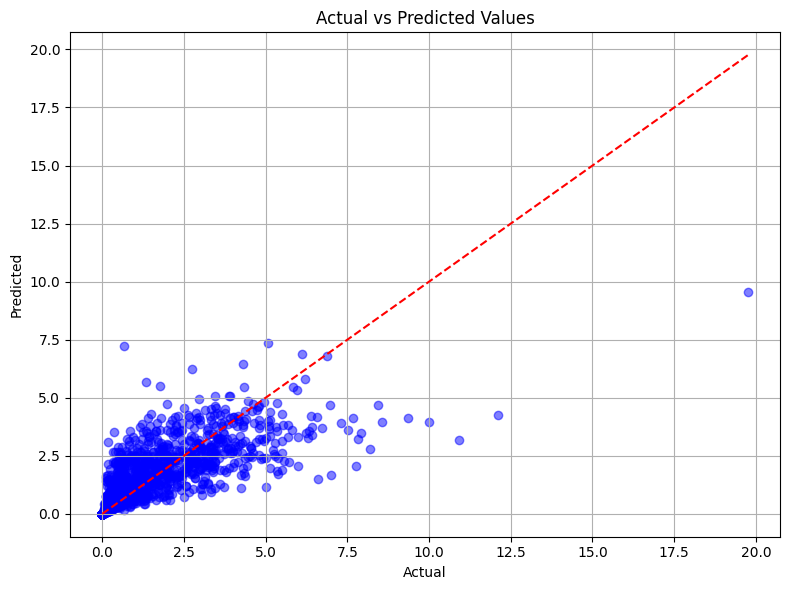

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print("📊 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Optional: Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, accuracy_score as acc_score

# Load data
iris = load_iris()
X, y = iris.data, iris.target

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train a classifier
clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)

# Option 1: Use model.score()
accuracy_via_score = clf.score(X_test, y_test)
print(f"Model.score() Accuracy: {accuracy_via_score:.2%}")

# Option 2: Use accuracy_score()
y_pred = clf.predict(X_test)
accuracy_via_metric = accuracy_score(y_test, y_pred)
print(f"accuracy_score(): {accuracy_via_metric:.2%}")

# Option 3 (optional): Get total correct count
num_correct = accuracy_score(y_test, y_pred, normalize=False)
print(f"Correct Predictions: {num_correct} / {len(y_test)}")

Model.score() Accuracy: 100.00%
accuracy_score(): 100.00%
Correct Predictions: 45.0 / 45


<ipython-input-26-2928779486>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')


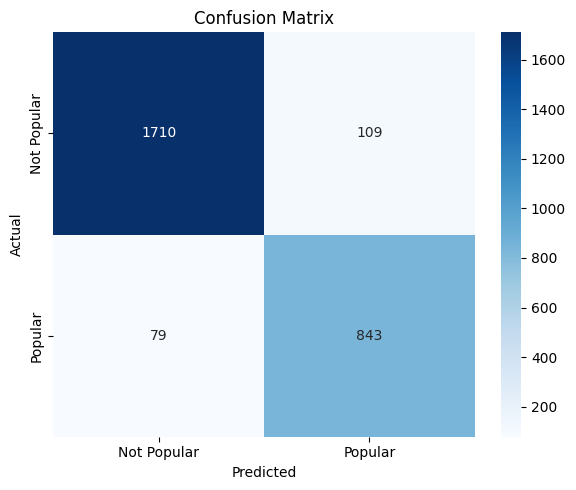

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# 1. Load dataset
df = pd.read_csv("/content/airbmbdataset.csv")

# 2. Create target column 'is_popular' from 'reviews_per_month'
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['is_popular'] = (df['reviews_per_month'] > 1).astype(int)

# 3. Clean data
df['name'] = df['name'].fillna("No name")
df['host_name'] = df['host_name'].fillna("Unknown")
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df = df[df['minimum_nights'].between(1, 365)]
df = df[df['number_of_reviews'] >= 0]
df = df[df['latitude'].between(-90, 90) & df['longitude'].between(-180, 180)]

# Extract date features
df['review_year'] = df['last_review'].dt.year.fillna(0).astype(int)
df['review_month'] = df['last_review'].dt.month.fillna(0).astype(int)

# Drop columns (only if they exist)
columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'location', 'reviews_per_month']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# 4. Define features and target
X = df.drop(columns=['is_popular'])
y = df['is_popular']

# Identify numeric and categorical features
numerical_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
                      'floor', 'noisedb', 'review_year', 'review_month']
categorical_features = ['neighbourhood_group', 'neighbourhood', 'room_type']

# Keep only existing columns
numerical_features = [col for col in numerical_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]

# 5. Preprocessing pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# 6. Model pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Train model
clf_pipeline.fit(X_train, y_train)

# 9. Predictions and confusion matrix
y_pred = clf_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

# 10. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Popular', 'Popular'],
            yticklabels=['Not Popular', 'Popular'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/airbmbdataset.csv")

# Fill missing values and create target
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['is_popular'] = (df['reviews_per_month'] > 1).astype(int)

# Fill name/host_name if present
if 'name' in df.columns:
    df['name'] = df['name'].fillna("No name")
if 'host_name' in df.columns:
    df['host_name'] = df['host_name'].fillna("Unknown")

# Convert 'last_review' to datetime safely
if 'last_review' in df.columns:
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    df['review_year'] = df['last_review'].dt.year.fillna(0).astype(int)
    df['review_month'] = df['last_review'].dt.month.fillna(0).astype(int)
else:
    df['review_year'] = 0
    df['review_month'] = 0

# Create derived feature: reviews per night (safe divide)
if 'number_of_reviews' in df.columns and 'minimum_nights' in df.columns:
    df['reviews_per_night'] = df['number_of_reviews'] / df['minimum_nights']
    df['reviews_per_night'] = df['reviews_per_night'].replace([float('inf'), -float('inf')], 0).fillna(0)
else:
    df['reviews_per_night'] = 0

# Binary feature if 'floor' exists
df['has_floor_info'] = df['floor'].notnull().astype(int) if 'floor' in df.columns else 0

# Binary feature if 'noisedb' exists
df['has_noisedb_info'] = df['noisedb'].notnull().astype(int) if 'noisedb' in df.columns else 0

# Area bucket from coordinates if available
if 'latitude' in df.columns and 'longitude' in df.columns:
    df['area_bucket'] = ((df['latitude'].round(1).astype(str)) + "_" +
                         (df['longitude'].round(1).astype(str)))
else:
    df['area_bucket'] = "unknown"

# Drop columns only if they exist
columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review', 'reviews_per_month', 'location']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# ✅ Preview final engineered dataset
print("Final engineered features:")
print(df.head())


Final engineered features:
  neighbourhood_group       neighbourhood  latitude  longitude  \
0           Manhattan      Hell's Kitchen  40.76489  -73.98493   
1            Brooklyn         South Slope  40.66829  -73.98779   
2           Manhattan     Upper West Side  40.79826  -73.96113   
3            Brooklyn  Bedford-Stuyvesant  40.68371  -73.94028   
4            Brooklyn     Windsor Terrace  40.65599  -73.97519   

         room_type  minimum_nights  number_of_reviews  floor  noise(dB)  \
0     Private room               2                430      1  56.054278   
1     Private room               4                167      1  69.056465   
2     Private room               2                113      1  56.054278   
3  Entire home/apt               2                 88      1  69.056465   
4     Private room               1                 19      1  69.056465   

                                            Location  is_popular  review_year  \
0  Fifty Third and Eighth, 301, West 53rd St

<ipython-input-28-1826375598>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
